In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT

# for creating custom gates
from qiskit import quantum_info as qi

# import basic plot tools
from qiskit.visualization import plot_histogram


# for simulation
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city


# blochsphere for debugging hopefully
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

## The asymmetric 4-city problem

solving the bottleneck travelling salesman problem using phase estimation.

### testing contraint:

 - 6 qubits for phase estimation.
 - 8 qubits initialized to the eigenvalue of the of the matrix $U$.
 - There are 6 hamilonian cycles, so we need eigenvalue and estimation qubits for each.
 - To solve the constraint problem we need a new operator $U$ satifying a max edge weight.
 
 - 12 edgeweights

<div>
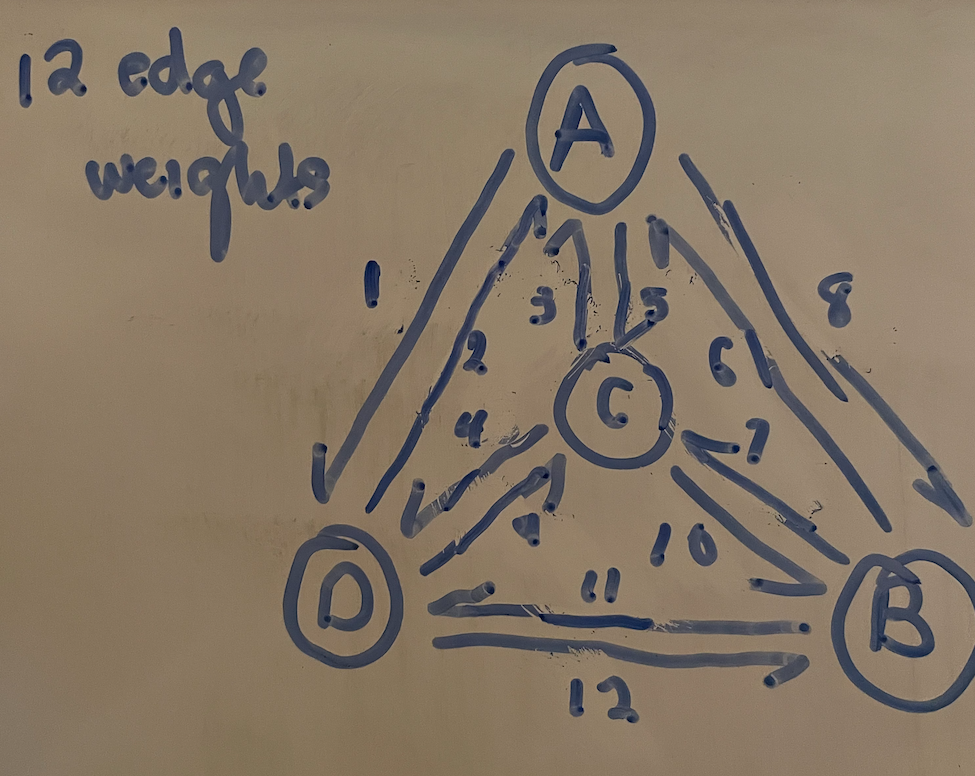
</div>

<div>
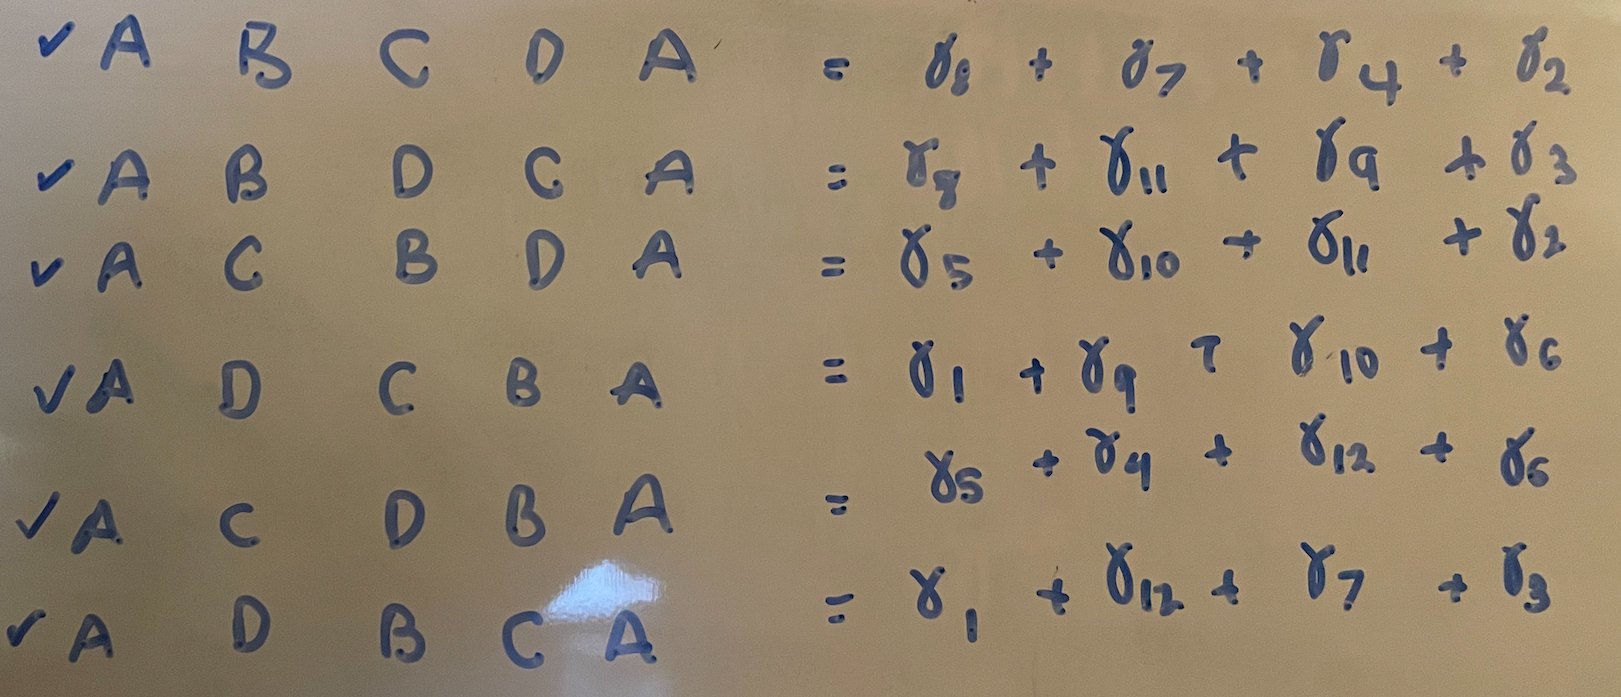
</div>

### we can assign arbitrary weights

$$\Large 1: A\xrightarrow{\gamma_8}B \xrightarrow{\gamma_7}C \xrightarrow{\gamma_4}D\xrightarrow{\gamma_2}A$$

$$\Large 2: A\xrightarrow{\gamma_8}B \xrightarrow{\gamma_{11}}D \xrightarrow{\gamma_9}C\xrightarrow{\gamma_3}A$$

$$\Large 3: A\xrightarrow{\gamma_5}C \xrightarrow{\gamma_{10}}B \xrightarrow{\gamma_{11}}D\xrightarrow{\gamma_2}A$$

$$\Large 4: A\xrightarrow{\gamma_1}D \xrightarrow{\gamma_9}C \xrightarrow{\gamma_{10}}B\xrightarrow{\gamma_6}A$$

$$\Large 5: A\xrightarrow{\gamma_5}C \xrightarrow{\gamma_4}D \xrightarrow{\gamma_{12}}B\xrightarrow{\gamma_6}A$$

$$\Large 6: A\xrightarrow{\gamma_{1}}D \xrightarrow{\gamma_{12}}B \xrightarrow{\gamma_7}C\xrightarrow{\gamma_3}A$$

In [2]:
### Design the test -> manually assigning weights and finding the solutions:

weights = np.arange(1,13,1)

### random seed approach might be worth while

#np.random.seed(5) # (2 solutions) one happens to be TSP solution
np.random.seed(0) #(1 solution) also a TSP solution

#weights = np.random.randint(1, high = 50, size = 12) # weights repeat
weights = np.random.choice(np.array(range(50)) + 1, 12, replace=False) # non repeating weights
print('weights: {}'.format(weights))


hamiltonian_cycles = ['8,7,4,2', '8,11,9,3', '5,10,11,2', '1,9,10,6','5,4,12,6','1,12,7,3']

for i, cycle in enumerate(hamiltonian_cycles):
    ham = 0
    edges = []
    for gamma in cycle.split(','):
        ham += weights[int(gamma) - 1]
        edges.append(weights[int(gamma) - 1])
    print("")
    print('hamiltonian cycle {}: {}'.format(i+1, ham))
    print('edge weights {}: {}'.format(i+1, edges))
    
    


weights: [29 12 11 42  3 28 39 32 23  5 34 36]

hamiltonian cycle 1: 125
edge weights 1: [32, 39, 42, 12]

hamiltonian cycle 2: 100
edge weights 2: [32, 34, 23, 11]

hamiltonian cycle 3: 54
edge weights 3: [3, 5, 34, 12]

hamiltonian cycle 4: 85
edge weights 4: [29, 23, 5, 28]

hamiltonian cycle 5: 109
edge weights 5: [3, 42, 36, 28]

hamiltonian cycle 6: 115
edge weights 6: [29, 36, 39, 11]


In [3]:
eigstatelist = ['11000110', '01101100', '10001101',
                '01110010', '11100001', '10110100']

n = 3 #estimation qubits
eig = eigstatelist[1] # 0,1 solutions -> 2, 
eig = eig[::-1] # needs to be reversed
sim_types = ['statevector_simulator', 'aer_simulator']
sim_type = sim_types[1] 


**we need to normalize by largest hamiltonian cycle**

we can just use the values we have above for now, but might be worth considering what strategy works best.
 - simplest solution would be to normalize based on the sum of all edge weights
 
 $$\Large w = \frac{w}{\mathrm{sum}(w)}$$

In [4]:
eps = 1
#weights = weights / (max(weights) + eps) * 2 * np.pi

weights = weights / (np.max(weights) * 4)
#weights = weights / np.sum(weights) * np.pi

print('normalized weights: {}'.format(weights))

## solutions

for i, cycle in enumerate(hamiltonian_cycles):
    ham = 0
    edges = []
    for gamma in cycle.split(','):
        ham += weights[int(gamma) - 1]
        edges.append(weights[int(gamma) - 1])
    print("")
    print('hamiltonian cycle {}: {:.2f}'.format(i+1, ham))
    print('edge weights {}: {:}'.format(i+1, np.round(edges, 2)))
    

normalized weights: [0.17261905 0.07142857 0.06547619 0.25       0.01785714 0.16666667
 0.23214286 0.19047619 0.13690476 0.0297619  0.20238095 0.21428571]

hamiltonian cycle 1: 0.74
edge weights 1: [0.19 0.23 0.25 0.07]

hamiltonian cycle 2: 0.60
edge weights 2: [0.19 0.2  0.14 0.07]

hamiltonian cycle 3: 0.32
edge weights 3: [0.02 0.03 0.2  0.07]

hamiltonian cycle 4: 0.51
edge weights 4: [0.17 0.14 0.03 0.17]

hamiltonian cycle 5: 0.65
edge weights 5: [0.02 0.25 0.21 0.17]

hamiltonian cycle 6: 0.68
edge weights 6: [0.17 0.21 0.23 0.07]


To construct $U$, we need to compute the tensor product of diagonal matrices $U_j$, where $ 1 \leq j \leq N$. $N$ denotes the number of cities in total.

$$\Large\left[U_j \right]_{kk} = \frac{1}{\sqrt{N}}e^{i\gamma_{jk}}$$


$$\Large U = \bigotimes_j^N U_j$$


for our contstraint test, we simply need a tensor product of 4 matrices:

$$\Large U = U_1 \otimes U_2 \otimes U_3 \otimes U_4$$

lets have a closer look at the matrix $U_1$
$$ \Large
\begin{bmatrix}
  1 & 0 & 0 & 0 \\
  0 & e^{i\gamma_{12}} & 0 & 0 \\
  0 & 0 & e^{i\gamma_{13}} & 0 \\
  0 & 0 & 0 & e^{i\gamma_{14}} \\
\end{bmatrix}
$$

constructing the large matrix U is straight forward. I am a little confused on how to construct a controlled-U operation such that we have the appropriate phase kickback. The 2018 paper does a decomposition, and claims that a $CU$ matrix can simply be achieved by the tensor product of the smaller $CU_J$ matrices. Need to confirm how this works.

A control gate can simply be constructed:

$$ \Large
\begin{bmatrix}
  \mathbb{1} & 0 \\
  0 & U \\
\end{bmatrix}
$$ 


#### clarification:

to construct a control gate, we need an equal amount of diagonal elements for the identity matrix above as we have in the diagonal of U, implying we double the size of U and store 1s in the first half of the diagonal. Ordering becomes an issue due to qiskit circuit convention, luckily they have a built in operator we can use.

## creating CU matrix

In [5]:
### need the four values for each sub distance matrix:
m = 8                                              # eigenvalue qubits


weight_locations = ['0,8,5,1', '6,0,7,11', '3,10,0,4', '2,12,9,0'] ## probably easier to write a for loop based on this


U111 = 1
U122 = np.exp(1j * weights[7] * 2 * np.pi)
U133 = np.exp(1j * weights[4] * 2 * np.pi)
U144 = np.exp(1j * weights[0] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[5] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[6] * 2 * np.pi)
U244 = np.exp(1j * weights[10] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[2] * 2 * np.pi)
U322 = np.exp(1j * weights[9] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[3] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[1] * 2 * np.pi)
U422 = np.exp(1j * weights[11] * 2 * np.pi)
U433 = np.exp(1j * weights[8] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(U) != 0))                    # confirming only the diagonal is being used.

Ugate = qi.Operator(U).to_instruction()
Ugate.label = "CU"
CUgate0 = Ugate.control()


True


## Confirming where the solutions are:



In [6]:
# solution 1: 2.1362830044410597
# solution 2: 2.1362830044410592
# solution 3: 2.0106192982974678
# U_angles = U_angles[U_angles > 2] ## range here is -pi to pi. Changing it to 0 to 2pi
# U_angles = U_angles[U_angles < 2.2]
# U_angles
#print(np.where(U_angles==2.0106)) ### solution 3
#print(np.where(U_angles == 2.1363)) ## solution 1 & 2


### according to May 2018 paper
U_angles = np.diag(np.angle(U))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
U_angles[eiglistint] + 1



array([0.50595238, 0.74404762, 0.64880952, 0.5952381 , 0.68452381,
       1.32142857])

## Creating CU Prime matrix (removing max edge weight)

In [7]:
x = "'"
print(x * 2)

''


In [8]:
### need the four values for each sub distance matrix:

   
    # Using globals() to create a global variable
for i in range(5):
    variable_name = "CUgate" + str(i+1) 
    #variable_value = 99
    #globals()[variable_name] = variable_value

    max_index = np.where(weights == np.max(weights))[0][0] ## largest weight in weights index
    weights[max_index] = 0                                 ## setting the largest weight to zero

    U111 = 1
    U122 = np.exp(1j * weights[7] * 2 * np.pi)
    U133 = np.exp(1j * weights[4] * 2 * np.pi)
    U144 = np.exp(1j * weights[0] * 2 * np.pi)
    U1 = np.diag([U111, U122, U133, U144])

    U211 = np.exp(1j * weights[5] * 2 * np.pi)
    U222 = 1
    U233 = np.exp(1j * weights[6] * 2 * np.pi)
    U244 = np.exp(1j * weights[10] * 2 * np.pi)
    U2 = np.diag([U211, U222, U233, U244])

    U311 = np.exp(1j * weights[2] * 2 * np.pi)
    U322 = np.exp(1j * weights[9] * 2 * np.pi)
    U333 = 1
    U344 = np.exp(1j * weights[3] * 2 * np.pi)
    U3 = np.diag([U311, U322, U333, U344])

    U411 = np.exp(1j * weights[1] * 2 * np.pi)
    U422 = np.exp(1j * weights[11] * 2 * np.pi)
    U433 = np.exp(1j * weights[8] * 2 * np.pi)
    U444 = 1
    U4 = np.diag([U411, U422, U433, U444])

    ## tensor product all of them
    ## Add ones to the diagonal (first half)

    Up = np.kron(np.kron(np.kron(U1,U2),U3),U4)
    print(np.all(np.diag(Up) != 0))# confirming only the diagonal is being used.

    UPgate = qi.Operator(Up).to_instruction()
    prime = "'"
    UPgate.label = "CU" + prime * (i + 1)
    globals()[variable_name] = UPgate.control()


True
True
True
True
True


In [9]:
U_angles = np.diag(np.angle(Up))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
U_angles[eiglistint] + 1


array([0.50595238, 1.07142857, 1.18452381, 1.20238095, 1.23809524,
       1.11904762])

In [10]:
registers = []
c_registers = []
p_registers = []
e_registers = []
for i in range(6):
    qr = QuantumRegister(n, name = 'phase_' + str(i))
    qr2 = QuantumRegister(m, name = 'eigenstate_'+ str(i))
    cr = ClassicalRegister(n, 'output_'+ str(i))
    registers.append(qr)
    registers.append(qr2)
    registers.append(cr)
    p_registers.append(qr)
    e_registers.append(qr2)
    c_registers.append(cr)

In [11]:
registers


[QuantumRegister(3, 'phase_0'),
 QuantumRegister(8, 'eigenstate_0'),
 ClassicalRegister(3, 'output_0'),
 QuantumRegister(3, 'phase_1'),
 QuantumRegister(8, 'eigenstate_1'),
 ClassicalRegister(3, 'output_1'),
 QuantumRegister(3, 'phase_2'),
 QuantumRegister(8, 'eigenstate_2'),
 ClassicalRegister(3, 'output_2'),
 QuantumRegister(3, 'phase_3'),
 QuantumRegister(8, 'eigenstate_3'),
 ClassicalRegister(3, 'output_3'),
 QuantumRegister(3, 'phase_4'),
 QuantumRegister(8, 'eigenstate_4'),
 ClassicalRegister(3, 'output_4'),
 QuantumRegister(3, 'phase_5'),
 QuantumRegister(8, 'eigenstate_5'),
 ClassicalRegister(3, 'output_5')]

/Users/raveel/miniconda3/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


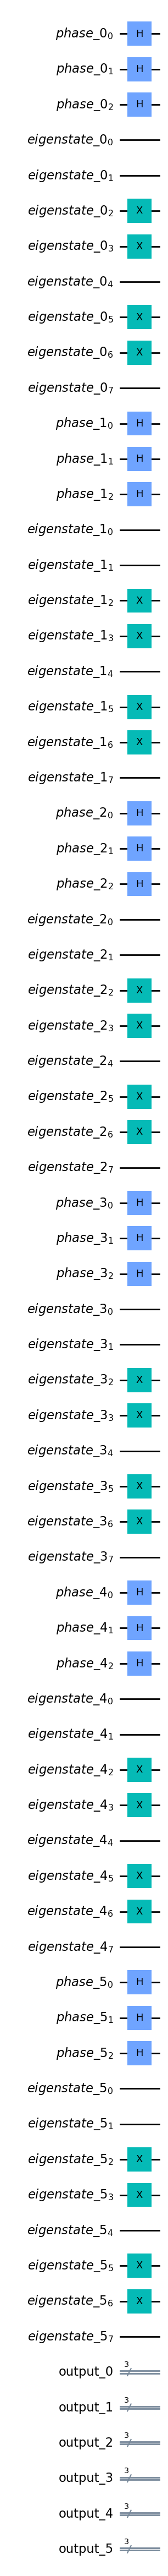

In [12]:

# qr = QuantumRegister(n, name = 'phase')
# qr2 = QuantumRegister(m, name = 'eigenstate')
# cr = ClassicalRegister(n, 'output')

# qrp = QuantumRegister(n, name = 'phase two')
# qr2p = QuantumRegister(m, name = 'eigstate two')
# crp = ClassicalRegister(n, 'output two')

qc = QuantumCircuit(*registers) #qrp,qr2p,crp)


# # Apply H-Gates to counting qubits:
# for qubit in range(2*n):
#     if qubit < n:
#         qc.h(qubit)
#     else:
#         qc.h(qubit + m)
        

# for ind, val in enumerate(eig):
#     if(int(val)):
#         qc.x(ind + n)
#         qc.x(ind + 2*n + m)

for i, qr in enumerate(registers):
        
    if i % 3 == 0:
        for qubit in qr:
            qc.h(qubit)
            
    elif i % 3 == 1:
        for val, qubit in zip(eig,qr):
            if(int(val)):
                qc.x(qubit)
            
qc.draw(output='mpl')



In [13]:
# eig_qubits = np.arange(0,m) + n
# eig_qubits2 = np.arange(0,m) + 2*n + m

# repetitions = 1
# for counting_qubit in range(n):
#     applied_qubits = np.append([counting_qubit], [eig_qubits])
#     applied_qubits2 = np.append([counting_qubit + m + n], [eig_qubits2])
#     for i in range(repetitions):
#         qc.append(CUgate, list(applied_qubits)); # This is CU
#         qc.append(CUPgate, list(applied_qubits2));
#     repetitions *= 2
    

for i, (phase, eigstate) in enumerate(zip(p_registers, e_registers)):
        repetitions = 1
        for qubit in (phase):
            applied_qubits = np.append([qubit], [eigstate])
            for j in range(repetitions):
                qc.append(globals()['CUgate' + str(i)], list(applied_qubits));
            repetitions *= 2
    
for phase, bits in zip(p_registers, c_registers):
    qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)
    qc.measure(phase,bits)
#qc.measure(qrp,crp)

#qc.draw(output='mpl')

In [24]:
qc.draw(output = 'mpl', fold=-1).savefig('asymmetric-4-city.pdf')



/Users/raveel/miniconda3/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [21]:
Aer.backends()


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [22]:
sim_type = 'qasm_simulator'

simulator = Aer.get_backend(sim_type)
simulator.configuration()

In [23]:
qc = transpile(qc, simulator)  #### Doesnt like the inverse Quantum Fourier transform without decomposition
#qc.draw()

TranspilerError: 'Number of qubits (66) in circuit-416 is greater than maximum (29) in the coupling_map'

In [19]:
# Run and get counts
result = simulator.run(qc).result()
counts = result.get_counts(qc)
#plot_histogram(counts, title='check')


AerError: 'unknown instruction: c-unitary'

In [ ]:
counts

In [ ]:
max(counts, key=counts.get)

In [ ]:
def bitstring_converter(string):
    
    values = []
    value = 0
    j = 0
    for i, v in enumerate(string):
        
        if v == '1':
            value += 1/(2**(i+1-j))
        elif v == " ":
            values.append(value)
            value = 0
            j = i+1
            
        if i == len(string)-1:
            values.append(value)
    
    return values

In [ ]:
bitstring_converter(max(counts, key=counts.get))

In [ ]:
np.arange(0,1, 1/(2**(n)))

In [ ]:
#plot_histogram(counts, title='check')